# CSE1904 -  Capstone Project<br>CNN-Based Method for Classifying Cervical Cancer Cells in Pap Smear Images

#### Remita Austin
#### Reg No: 19BCE1637
#### Faculty Guide: Dr. Parvathi R

In [ ]:
#Import the required libraries
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
import visualkeras
from PIL import Image
import tensorflow as tf 
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import VGG19
from keras.applications.densenet import DenseNet201
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization, Input, Conv2D, GlobalAveragePooling2D
from tensorflow.keras import models, layers
from tensorflow.keras import Model
import glob
from tensorflow.keras.utils import load_img
from keras.regularizers import l2

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"remitaaustin","key":"ea6a1036a48b76c285eddd90e6a0e37d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## Working with the SIPaKMeD FCI Dataset

In [ ]:
!kaggle datasets download prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed -p /content/sample_data/archive/ --unzip

100% 6.40G/6.40G [04:33<00:00, 24.9MB/s]
100% 6.40G/6.40G [04:33<00:00, 25.2MB/s]


In [ ]:
def FormatDataset(dataset_src, dataset_dest, classes):
    #Making a copy of dataset
    new_cropped_dest = [os.path.join(dataset_dest, cls) for cls in classes]
    cropped_src = [ dataset_src + "/im_" + cls + "/im_" + cls + "/CROPPED" for cls in classes ]
    complete_src = [ dataset_src + "/im_" + cls + "/im_" + cls for cls in classes ]
    for (dest1) in (new_cropped_dest):
        os.makedirs(dest1)
    #Formating cropped images
    for (src,new_dest) in zip(cropped_src, new_cropped_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file)
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg')
                img = cv2.imread(os.path.join(src, file))
                img = cv2.resize(img, (64, 64))
                img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)
                img = cv2.blur(img, (2, 2))
                cv2.imwrite(img_des ,img)

#Source location for dataset
src = './sample_data/archive'
#Destination location for dataset
dest = './sample_data/CervicalCancer'
#Image classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
#Formatting dataset
FormatDataset(src, dest, classes)

In [ ]:
def GetDatasetSize(path, classes):
    num_of_image = {}
    for cls in classes:
        #Counting the number of files in the directory
        num_of_image[cls] = len(os.listdir(os.path.join(path, cls)))
    return num_of_image

In [ ]:
root_dir = "./sample_data/CervicalCancer"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

print(GetDatasetSize(root_dir, classes))

{'Dyskeratotic': 813, 'Koilocytotic': 825, 'Metaplastic': 793, 'Parabasal': 787, 'Superficial-Intermediate': 831}


Inference: Above is category-wise frequency of the dataset.

In [ ]:
#Understanding the files in different data directories
dys_data = os.listdir('sample_data/CervicalCancer/Dyskeratotic/')
print("Dyskeratotic: ",dys_data[:10])

koi_data = os.listdir('sample_data/CervicalCancer/Koilocytotic/')
print("Koilocytotic: ",koi_data[:10])

met_data = os.listdir('sample_data/CervicalCancer/Metaplastic/')
print("Metaplastic: ",met_data[:10])

par_data = os.listdir('sample_data/CervicalCancer/Parabasal/')
print("Parabasal: ",par_data[:10])

sup_data = os.listdir('sample_data/CervicalCancer/Superficial-Intermediate/')
print("Superficial-Intermediate: ",sup_data[:10])

Dyskeratotic:  ['101_15.jpg', '156_04.jpg', '184_04.jpg', '163_03.jpg', '049_02.jpg', '120_02.jpg', '167_02.jpg', '101_03.jpg', '015_01.jpg', '125_02.jpg']
Koilocytotic:  ['105_05.jpg', '156_04.jpg', '105_16.jpg', '163_03.jpg', '049_02.jpg', '120_02.jpg', '121_07.jpg', '101_03.jpg', '015_01.jpg', '088_04.jpg']
Metaplastic:  ['184_04.jpg', '239_01.jpg', '167_02.jpg', '101_03.jpg', '015_01.jpg', '088_04.jpg', '025_08.jpg', '267_01.jpg', '147_01.jpg', '170_05.jpg']
Parabasal:  ['045_07.jpg', '048_05.jpg', '049_02.jpg', '065_07.jpg', '101_03.jpg', '015_01.jpg', '064_06.jpg', '020_03.jpg', '093_26.jpg', '051_03.jpg']
Superficial-Intermediate:  ['045_07.jpg', '126_05.jpg', '049_02.jpg', '061_09.jpg', '120_02.jpg', '121_07.jpg', '101_03.jpg', '015_01.jpg', '125_02.jpg', '020_03.jpg']


In [ ]:
def view_random_image(target_dir, target_class):
  #setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = mpimg.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img

Image shape: (66, 66, 3)


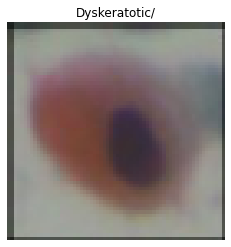

In [ ]:
img = view_random_image(target_dir = "sample_data/CervicalCancer/",target_class='Dyskeratotic/')

Image shape: (66, 66, 3)


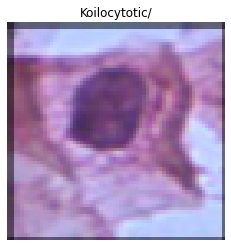

In [ ]:
img = view_random_image(target_dir = "sample_data/CervicalCancer/",target_class='Koilocytotic/')

Image shape: (66, 66, 3)


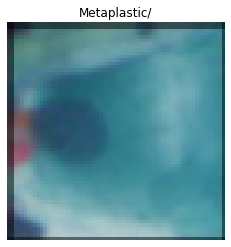

In [ ]:
img = view_random_image(target_dir = "sample_data/CervicalCancer/",target_class='Metaplastic/')

Image shape: (66, 66, 3)


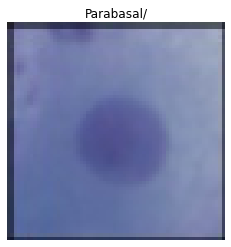

In [ ]:
img = view_random_image(target_dir = "sample_data/CervicalCancer/",target_class='Parabasal/')

Image shape: (66, 66, 3)


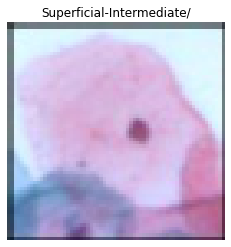

In [ ]:
img = view_random_image(target_dir = "sample_data/CervicalCancer/",target_class='Superficial-Intermediate/')

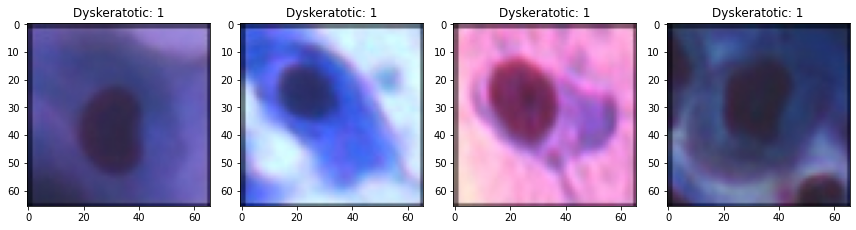

In [ ]:
#Class- Dyskeratotic (abnormal)
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread('sample_data/CervicalCancer/Dyskeratotic/' + "/" + dys_data[i])
    plt.imshow(img)
    plt.title('Dyskeratotic: 1')
    plt.tight_layout()
plt.show()

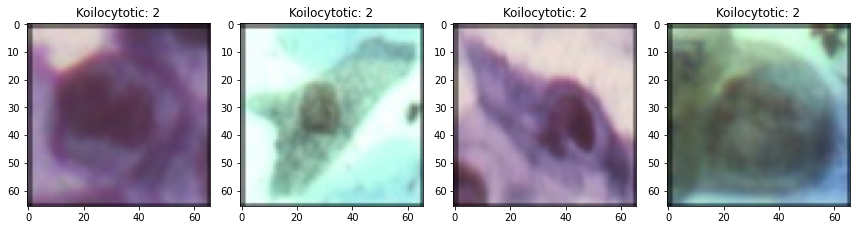

In [ ]:
#Class- Koilocytotic (abnormal)
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread('sample_data/CervicalCancer/Koilocytotic/' + "/" + koi_data[i])
    plt.imshow(img)
    plt.title('Koilocytotic: 2')
    plt.tight_layout()
plt.show()

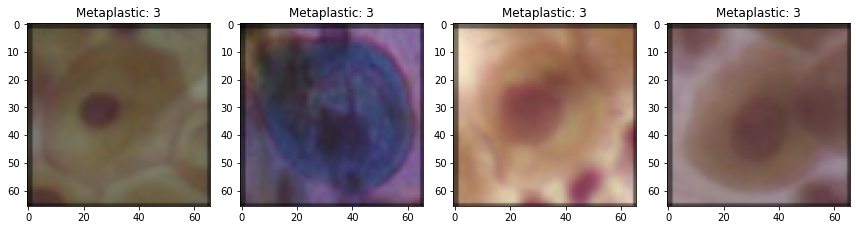

In [ ]:
#Class- Metaplastic (benign)
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread('sample_data/CervicalCancer/Metaplastic/' + "/" + met_data[i])
    plt.imshow(img)
    plt.title('Metaplastic: 3')
    plt.tight_layout()
plt.show()

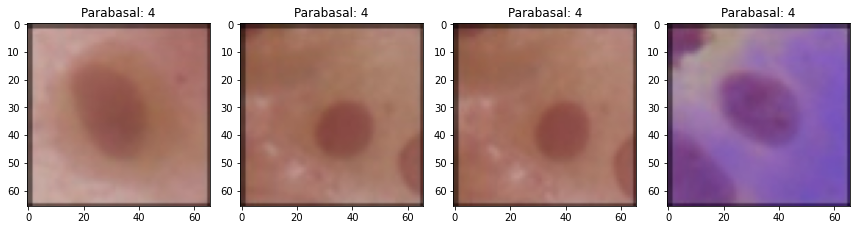

In [ ]:
#Class- Parabasal (normal)
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread('sample_data/CervicalCancer/Parabasal/' + "/" + par_data[i])
    plt.imshow(img)
    plt.title('Parabasal: 4')
    plt.tight_layout()
plt.show()

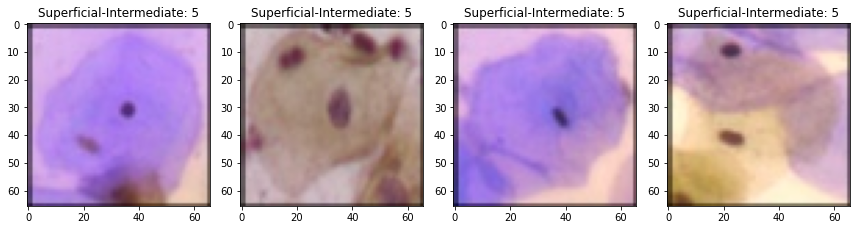

In [ ]:
#Class- Superficial-Intermediate (normal)
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread('sample_data/CervicalCancer/Superficial-Intermediate/' + "/" + sup_data[i])
    plt.imshow(img)
    plt.title('Superficial-Intermediate: 5')
    plt.tight_layout()
plt.show()

Inference: The image shape shows a tuple of (row (height), column (width), color (3)) which is (66,66,3). The data visualization shows that Dyskeratotic and Koilocytotic groups are considered abnormal, Metaplastic is considered Benign, and Parabasal and Superficial-Intermediate are considered normal.

### Applying Pre-trained Models over Original Images

In [ ]:
def TrainTestValSplit(root_dir, classes_dir, val_ratio = 0.1, test_ratio = 0.1):
    for cls in classes_dir:
        #Creating separate folders
        os.makedirs('sample_data/train_org/' + cls)
        os.makedirs('sample_data/test_org/' + cls)
        os.makedirs('sample_data/val_org/' + cls)
        
        src = os.path.join(root_dir, cls)

        #Spliting the image files in the given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

        #To display the split details
        print(cls,':')
        print('Total Images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Testing: ', len(test_FileNames))
        print('Validation: ', len(val_FileNames))
        
        for name in train_FileNames:
            shutil.copy(name, 'sample_data/train_org/' + cls)
        for name in test_FileNames:
            shutil.copy(name, 'sample_data/test_org/' + cls)
        for name in val_FileNames:
            shutil.copy(name, 'sample_data/val_org/' + cls)

        print()

root_dir = "./sample_data/CervicalCancer"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
TrainTestValSplit(root_dir, classes)

Dyskeratotic :
Total Images:  813
Training:  650
Testing:  82
Validation:  81

Koilocytotic :
Total Images:  825
Training:  660
Testing:  83
Validation:  82

Metaplastic :
Total Images:  793
Training:  634
Testing:  80
Validation:  79

Parabasal :
Total Images:  787
Training:  629
Testing:  79
Validation:  79

Superficial-Intermediate :
Total Images:  831
Training:  664
Testing:  84
Validation:  83



In [ ]:
train_org_dir = "sample_data/train_org/"
test_org_dir = "sample_data/test_org/"
val_org_dir = "sample_data/val_org/"

#Rescaling
train_org = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1./255, horizontal_flip=True)
test_org = ImageDataGenerator(rescale = 1./255)
val_org = ImageDataGenerator(rescale = 1./255)

#Transfer the data from directories to batches
train_org_data = train_org.flow_from_directory(directory = train_org_dir,
                                               batch_size= 32,
                                               target_size= (75,75),
                                               class_mode = "categorical")

train_org_data.class_indices

Found 3237 images belonging to 5 classes.


{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [ ]:
test_org_data = test_org.flow_from_directory(directory = test_org_dir,
                                               batch_size = 32,
                                               target_size = (75,75),
                                               class_mode = "categorical")

val_org_data = val_org.flow_from_directory(directory = val_org_dir,
                                               batch_size = 32,
                                               target_size = (75,75),
                                               class_mode = "categorical")

Found 408 images belonging to 5 classes.
Found 404 images belonging to 5 classes.


#### Using ResNet50 Model

In [ ]:
base_model = ResNet50(input_shape=(66,66,3),
                      include_top=False,)

for layer in base_model.layers:
       layer.trainable = False

In [ ]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(layers.Dropout(0.25))
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_resnet.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 dropout_23 (Dropout)        (None, 3, 3, 2048)        0         
                                                                 
 flatten_12 (Flatten)        (None, 18432)             0         
                                                                 
 dropout_24 (Dropout)        (None, 18432)             0         
                                                                 
 dense_13 (Dense)            (None, 5)                 92165     
                                                                 
Total params: 23,679,877
Trainable params: 92,165
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_resnet_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
resnet = model_resnet.fit(
    train_org_data, 
    steps_per_epoch = len(train_org_data), 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = len(val_org_data),
    callbacks = call_back 
    )

Epoch 1/5
102/102 [==============================] - 77s 710ms/step - loss: 1.8268 - accuracy: 0.2527 - precision: 0.2878 - recall: 0.0989 - val_loss: 1.3574 - val_accuracy: 0.4381 - val_precision: 0.7059 - val_recall: 0.0891
Epoch 2/5
102/102 [==============================] - 71s 694ms/step - loss: 1.6659 - accuracy: 0.3043 - precision: 0.3709 - recall: 0.1251 - val_loss: 1.4005 - val_accuracy: 0.3020 - val_precision: 0.5487 - val_recall: 0.1535
Epoch 3/5
102/102 [==============================] - 68s 666ms/step - loss: 1.6393 - accuracy: 0.3210 - precision: 0.3880 - recall: 0.1498 - val_loss: 1.3128 - val_accuracy: 0.4777 - val_precision: 0.7500 - val_recall: 0.0223
Epoch 4/5
102/102 [==============================] - 68s 672ms/step - loss: 1.6125 - accuracy: 0.3411 - precision: 0.4135 - recall: 0.1764 - val_loss: 1.3184 - val_accuracy: 0.5149 - val_precision: 0.7949 - val_recall: 0.0767
Epoch 5/5
102/102 [==============================] - 71s 698ms/step - loss: 1.6035 - accuracy: 0

In [ ]:
#Loading the best fit model
resnet_model = load_model("./oc_resnet_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[1]
precision_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[2]
recall_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_resnet_org*100} %")
print(f"Precision = {precision_resnet_org*100} %")
print(f"Recall = {recall_resnet_org*100} %")

<ipython-input-107-c0aefe10376c>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[1]
<ipython-input-107-c0aefe10376c>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[2]
<ipython-input-107-c0aefe10376c>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[3]


Accuracy = 47.05882370471954 %
Precision = 75.67567825317383 %
Recall = 6.862745434045792 %


#### Using VGG16 Model

In [ ]:
model_VGG = VGG16(
    input_shape = (66,66,3),
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16 = Sequential()
vgg16.add(model_VGG)
vgg16.add(layers.Dropout(0.25))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 14,724,933
Trainable params: 10,245
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg16.fit(
    train_org_data,
    steps_per_epoch = train_org_data.samples//train_org_data.batch_size, 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = val_org_data.samples//val_org_data.batch_size,
    callbacks=call_back
)

Epoch 1/5
101/101 [==============================] - 161s 2s/step - loss: 1.1469 - accuracy: 0.5582 - precision: 0.7152 - recall: 0.3401 - val_loss: 0.7596 - val_accuracy: 0.7474 - val_precision: 0.8523 - val_recall: 0.5859
Epoch 2/5
101/101 [==============================] - 160s 2s/step - loss: 0.8040 - accuracy: 0.7055 - precision: 0.8103 - recall: 0.5704 - val_loss: 0.6873 - val_accuracy: 0.7682 - val_precision: 0.8469 - val_recall: 0.6484
Epoch 3/5
101/101 [==============================] - 164s 2s/step - loss: 0.7316 - accuracy: 0.7357 - precision: 0.8109 - recall: 0.6384 - val_loss: 0.5978 - val_accuracy: 0.7734 - val_precision: 0.8664 - val_recall: 0.6927
Epoch 4/5
101/101 [==============================] - 164s 2s/step - loss: 0.6973 - accuracy: 0.7438 - precision: 0.8064 - recall: 0.6590 - val_loss: 0.6057 - val_accuracy: 0.7760 - val_precision: 0.8308 - val_recall: 0.7031
Epoch 5/5
101/101 [==============================] - 159s 2s/step - loss: 0.6646 - accuracy: 0.7591 - pr

In [ ]:
#Loading the best fit model
modelVGG = load_model("./oc_vgg_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[1]
precision_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[2]
recall_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_vgg_org*100} %")
print(f"Precision = {precision_vgg_org*100} %")
print(f"Recall = {recall_vgg_org*100} %")

<ipython-input-25-1a834e9639e2>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[1]
<ipython-input-25-1a834e9639e2>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[2]
<ipython-input-25-1a834e9639e2>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[3]


Accuracy = 81.3725471496582 %
Precision = 87.53623366355896 %
Recall = 74.01960492134094 %


#### Using VGG19 Model

In [ ]:
model_VGG = VGG19(
    input_shape = (66,66,3),
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
vgg19 = Sequential()
vgg19.add(model_VGG)
vgg19.add(layers.Dropout(0.25))
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg19.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 20,034,629
Trainable params: 10,245
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg19_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg19.fit(
    train_org_data,
    steps_per_epoch = train_org_data.samples//train_org_data.batch_size, 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = val_org_data.samples//val_org_data.batch_size,
    callbacks=call_back
)

Epoch 1/5
101/101 [==============================] - 199s 2s/step - loss: 1.2180 - accuracy: 0.5273 - precision: 0.6718 - recall: 0.3435 - val_loss: 0.8258 - val_accuracy: 0.7266 - val_precision: 0.8104 - val_recall: 0.5677
Epoch 2/5
101/101 [==============================] - 218s 2s/step - loss: 0.8208 - accuracy: 0.6998 - precision: 0.7964 - recall: 0.5797 - val_loss: 0.7199 - val_accuracy: 0.7422 - val_precision: 0.8182 - val_recall: 0.6328
Epoch 3/5
101/101 [==============================] - 198s 2s/step - loss: 0.7570 - accuracy: 0.7248 - precision: 0.7964 - recall: 0.6284 - val_loss: 0.7456 - val_accuracy: 0.7188 - val_precision: 0.8033 - val_recall: 0.6380
Epoch 4/5
101/101 [==============================] - 201s 2s/step - loss: 0.7266 - accuracy: 0.7348 - precision: 0.8041 - recall: 0.6479 - val_loss: 0.6473 - val_accuracy: 0.7682 - val_precision: 0.8462 - val_recall: 0.6875
Epoch 5/5
101/101 [==============================] - 217s 2s/step - loss: 0.6849 - accuracy: 0.7529 - pr

In [ ]:
#Loading the best fit model
modelVGG19 = load_model("./oc_vgg19_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[1]
precision_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[2]
recall_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_vgg19_org*100} %")
print(f"Precision = {precision_vgg19_org*100} %")
print(f"Recall = {recall_vgg19_org*100} %")

<ipython-input-32-ccac99d9fbee>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[1]
<ipython-input-32-ccac99d9fbee>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[2]
<ipython-input-32-ccac99d9fbee>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[3]


Accuracy = 75.49019455909729 %
Precision = 84.36577916145325 %
Recall = 70.09803652763367 %


#### Using DenseNet121 Model

In [ ]:
model_densenet121 = DenseNet121(
    input_shape = (66,66,3),
    include_top = False
    )

for layer in model_densenet121.layers:
       layer.trainable = False

In [ ]:
densenet121 = tf.keras.Sequential()
densenet121.add(model_densenet121)
densenet121.add(layers.Dropout(0.25))
densenet121.add(layers.Flatten())
densenet121.add(layers.Dropout(0.5))
densenet121.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet121.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet121.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 dropout_17 (Dropout)        (None, 2, 2, 1024)        0         
                                                                 
 flatten_9 (Flatten)         (None, 4096)              0         
                                                                 
 dropout_18 (Dropout)        (None, 4096)              0         
                                                                 
 dense_10 (Dense)            (None, 5)                 20485     
                                                                 
Total params: 7,057,989
Trainable params: 20,485
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet121_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet121.fit(
    train_org_data,
    steps_per_epoch = train_org_data.samples//train_org_data.batch_size, 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = val_org_data.samples//val_org_data.batch_size,
    callbacks=call_back
)

Epoch 1/5
101/101 [==============================] - 56s 484ms/step - loss: 1.3026 - accuracy: 0.6424 - precision: 0.6658 - recall: 0.6147 - val_loss: 0.6467 - val_accuracy: 0.8073 - val_precision: 0.8234 - val_recall: 0.7891
Epoch 2/5
101/101 [==============================] - 52s 518ms/step - loss: 0.9501 - accuracy: 0.7404 - precision: 0.7530 - recall: 0.7267 - val_loss: 0.4318 - val_accuracy: 0.8516 - val_precision: 0.8730 - val_recall: 0.8411
Epoch 3/5
101/101 [==============================] - 46s 448ms/step - loss: 0.9052 - accuracy: 0.7716 - precision: 0.7793 - recall: 0.7601 - val_loss: 0.4586 - val_accuracy: 0.8620 - val_precision: 0.8730 - val_recall: 0.8411
Epoch 4/5
101/101 [==============================] - 47s 460ms/step - loss: 0.8378 - accuracy: 0.7869 - precision: 0.7962 - recall: 0.7788 - val_loss: 0.5277 - val_accuracy: 0.8698 - val_precision: 0.8833 - val_recall: 0.8672
Epoch 5/5
101/101 [==============================] - 47s 460ms/step - loss: 0.8800 - accuracy: 0

In [ ]:
#Loading the best fit model
modeldensenet121 = load_model("./oc_densenet121_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[1]
precision_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[2]
recall_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_densenet121_org*100} %")
print(f"Precision = {precision_densenet121_org*100} %")
print(f"Recall = {recall_densenet121_org*100} %")

<ipython-input-82-f365a3fe878f>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[1]
<ipython-input-82-f365a3fe878f>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[2]
<ipython-input-82-f365a3fe878f>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[3]


Accuracy = 85.04902124404907 %
Precision = 86.83544397354126 %
Recall = 84.06862616539001 %


#### Using DenseNet201 Model

In [ ]:
model_densenet = DenseNet201(
    input_shape = (66,66,3),
    include_top = False
    )

for layer in model_densenet.layers:
       layer.trainable = False

In [ ]:
densenet201 = Sequential()
densenet201.add(model_densenet)
densenet201.add(layers.Dropout(0.25))
densenet201.add(layers.Flatten())
densenet201.add(layers.Dropout(0.5))
densenet201.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet201.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet201.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 2, 1920)        18321984  
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 1920)        0         
                                                                 
 flatten_1 (Flatten)         (None, 7680)              0         
                                                                 
 dropout_3 (Dropout)         (None, 7680)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 38405     
                                                                 
Total params: 18,360,389
Trainable params: 38,405
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet201.fit(
    train_org_data,
    steps_per_epoch = train_org_data.samples//train_org_data.batch_size, 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = val_org_data.samples//val_org_data.batch_size,
    callbacks=call_back
)

Epoch 1/5
101/101 [==============================] - 116s 987ms/step - loss: 1.0711 - accuracy: 0.6802 - precision: 0.7192 - recall: 0.6378 - val_loss: 0.4795 - val_accuracy: 0.8411 - val_precision: 0.8630 - val_recall: 0.8203
Epoch 2/5
101/101 [==============================] - 94s 931ms/step - loss: 0.7611 - accuracy: 0.7772 - precision: 0.8000 - recall: 0.7587 - val_loss: 0.4515 - val_accuracy: 0.8490 - val_precision: 0.8676 - val_recall: 0.8359
Epoch 3/5
101/101 [==============================] - 92s 914ms/step - loss: 0.7226 - accuracy: 0.7947 - precision: 0.8093 - recall: 0.7825 - val_loss: 0.4943 - val_accuracy: 0.8307 - val_precision: 0.8529 - val_recall: 0.8151
Epoch 4/5
101/101 [==============================] - 92s 911ms/step - loss: 0.6656 - accuracy: 0.8156 - precision: 0.8269 - recall: 0.8034 - val_loss: 0.5260 - val_accuracy: 0.8073 - val_precision: 0.8240 - val_recall: 0.8047
Epoch 5/5
101/101 [==============================] - 96s 951ms/step - loss: 0.7605 - accuracy: 

In [ ]:
#Loading the best fit model
modeldensenet = load_model("./oc_densenet_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[1]
precision_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[2]
recall_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_densenet_org*100} %")
print(f"Precision = {precision_densenet_org*100} %")
print(f"Recall = {recall_densenet_org*100} %")

<ipython-input-25-aa3836dc302c>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[1]
<ipython-input-25-aa3836dc302c>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[2]
<ipython-input-25-aa3836dc302c>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[3]


Accuracy = 85.53921580314636 %
Precision = 86.80202960968018 %
Recall = 83.82353186607361 %


#### Using InceptionV3 Model

In [ ]:
base_model = InceptionV3(input_shape = (75,75,3), 
                         include_top = False,)

for layer in base_model.layers:
       layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_incep = tf.keras.models.Model(base_model.input, x)

model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_inception_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [mc];

In [ ]:
#Fitting the model
incep = model_incep.fit(
    train_org_data, 
    steps_per_epoch = train_org_data.samples//train_org_data.batch_size, 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = val_org_data.samples//val_org_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/5
101/101 [==============================] - 36s 305ms/step - loss: 1.4157 - accuracy: 0.6150 - precision: 0.6570 - recall: 0.5373 - val_loss: 1.1134 - val_accuracy: 0.6432 - val_precision: 0.6754 - val_recall: 0.6068
Epoch 2/5
101/101 [==============================] - 30s 293ms/step - loss: 0.8918 - accuracy: 0.6989 - precision: 0.7350 - recall: 0.6509 - val_loss: 0.7441 - val_accuracy: 0.7214 - val_precision: 0.7805 - val_recall: 0.6667
Epoch 3/5
101/101 [==============================] - 28s 279ms/step - loss: 0.7786 - accuracy: 0.7470 - precision: 0.7773 - recall: 0.7036 - val_loss: 0.8631 - val_accuracy: 0.6589 - val_precision: 0.7109 - val_recall: 0.6276
Epoch 4/5
101/101 [==============================] - 28s 278ms/step - loss: 0.7254 - accuracy: 0.7516 - precision: 0.7815 - recall: 0.7220 - val_loss: 0.9881 - val_accuracy: 0.6536 - val_precision: 0.6884 - val_recall: 0.6328
Epoch 5/5
101/101 [==============================] - 29s 288ms/step - loss: 0.7115 - accuracy: 0

In [ ]:
#Loading the best fit model
inceptionv3_model = load_model("./oc_inception_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[1]
precision_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[2]
recall_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_incep_org*100} %")
print(f"Precision = {precision_incep_org*100} %")
print(f"Recall = {recall_incep_org*100} %")

<ipython-input-54-5fb1ac8bdcbb>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[1]
<ipython-input-54-5fb1ac8bdcbb>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[2]
<ipython-input-54-5fb1ac8bdcbb>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[3]


Accuracy = 76.96078419685364 %
Precision = 78.60962748527527 %
Recall = 72.0588207244873 %


#### Using Xception Model

In [ ]:
base_model = Xception(input_shape=(71,71,3),
                      include_top=False,)

for layer in base_model.layers:
       layer.trainable = False

In [ ]:
model_xception = Sequential()
model_xception.add(base_model)
model_xception.add(layers.Dropout(0.25))
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_xception.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 dropout_21 (Dropout)        (None, 3, 3, 2048)        0         
                                                                 
 flatten_11 (Flatten)        (None, 18432)             0         
                                                                 
 dropout_22 (Dropout)        (None, 18432)             0         
                                                                 
 dense_12 (Dense)            (None, 5)                 92165     
                                                                 
Total params: 20,953,645
Trainable params: 92,165
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_xception_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
xception = model_xception.fit(
    train_org_data, 
    steps_per_epoch = len(train_org_data), 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = len(val_org_data),
    callbacks = call_back 
    )

Epoch 1/5
102/102 [==============================] - 77s 715ms/step - loss: 1.1956 - accuracy: 0.7003 - precision: 0.7306 - recall: 0.6651 - val_loss: 0.8155 - val_accuracy: 0.7797 - val_precision: 0.8026 - val_recall: 0.7550
Epoch 2/5
102/102 [==============================] - 75s 728ms/step - loss: 1.1091 - accuracy: 0.7593 - precision: 0.7761 - recall: 0.7430 - val_loss: 0.6611 - val_accuracy: 0.8193 - val_precision: 0.8460 - val_recall: 0.8020
Epoch 3/5
102/102 [==============================] - 72s 708ms/step - loss: 0.9812 - accuracy: 0.7831 - precision: 0.7947 - recall: 0.7643 - val_loss: 0.7003 - val_accuracy: 0.8193 - val_precision: 0.8261 - val_recall: 0.7995
Epoch 4/5
102/102 [==============================] - 75s 731ms/step - loss: 1.0212 - accuracy: 0.7964 - precision: 0.8067 - recall: 0.7853 - val_loss: 0.7709 - val_accuracy: 0.8342 - val_precision: 0.8440 - val_recall: 0.8168
Epoch 5/5
102/102 [==============================] - 74s 727ms/step - loss: 1.0005 - accuracy: 0

In [ ]:
#Loading the best fit model
xception_model = load_model("./oc_xception_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_xception_org = xception_model.evaluate_generator(generator= test_org_data)[1]
precision_xception_org = xception_model.evaluate_generator(generator= test_org_data)[2]
recall_xception_org = xception_model.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_xception_org*100} %")
print(f"Precision = {precision_xception_org*100} %")
print(f"Recall = {recall_xception_org*100} %")

<ipython-input-97-bc987c8cd2b1>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_xception_org = xception_model.evaluate_generator(generator= test_org_data)[1]
<ipython-input-97-bc987c8cd2b1>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_xception_org = xception_model.evaluate_generator(generator= test_org_data)[2]
<ipython-input-97-bc987c8cd2b1>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_xception_org = xception_model.evaluate_generator(generator= test_org_data)[3]


Accuracy = 82.84313678741455 %
Precision = 83.83838534355164 %
Recall = 81.3725471496582 %


### Data Augmentation

In [ ]:
def blur(img):
    return (cv2.blur(img,(5,5)))

datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        preprocessing_function=blur)

In [ ]:
#Data augmentation of Dyskeratotic image class
image_directory = 'sample_data/CervicalCancer/Dyskeratotic/'
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((75,75))
        dataset.append(np.array(image))

x = np.array(dataset)
j = 0

for batch in datagen.flow(x, batch_size=8,  
                          save_to_dir='sample_data/Augmented/Dyskeratotic', 
                          save_prefix='aug', 
                          save_format='jpeg'):
    j += 1
    if j > i:
        break

In [ ]:
#Data augmentation of Koilocytotic image class
image_directory = 'sample_data/CervicalCancer/Koilocytotic/'
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((75,75))
        dataset.append(np.array(image))

x = np.array(dataset)
j = 0

for batch in datagen.flow(x, batch_size=8,  
                          save_to_dir='sample_data/Augmented/Koilocytotic', 
                          save_prefix='aug', 
                          save_format='jpeg'):
    j += 1
    if j > i:
        break

In [ ]:
#Data augmentation of Metaplastic image class
image_directory = 'sample_data/CervicalCancer/Metaplastic/'
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((75,75))
        dataset.append(np.array(image))

x = np.array(dataset)
j = 0

for batch in datagen.flow(x, batch_size=8,  
                          save_to_dir='sample_data/Augmented/Metaplastic', 
                          save_prefix='aug', 
                          save_format='jpeg'):
    j += 1
    if j > i:
        break

In [ ]:
#Data augmentation of Parabasal image class
image_directory = 'sample_data/CervicalCancer/Parabasal/'
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((75,75))
        dataset.append(np.array(image))

x = np.array(dataset)
j = 0

for batch in datagen.flow(x, batch_size=8,  
                          save_to_dir='sample_data/Augmented/Parabasal', 
                          save_prefix='aug', 
                          save_format='jpeg'):
    j += 1
    if j > i:
        break

In [ ]:
#Data augmentation of Superficial-Intermediate image class
image_directory = 'sample_data/CervicalCancer/Superficial-Intermediate/'
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((75,75))
        dataset.append(np.array(image))

x = np.array(dataset)
j = 0

for batch in datagen.flow(x, batch_size=8,  
                          save_to_dir='sample_data/Augmented/Superficial-Intermediate', 
                          save_prefix='aug', 
                          save_format='jpeg'):
    j += 1
    if j > i:
        break

In [ ]:
root_dir = "./sample_data/Augmented"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

print(GetDatasetSize(root_dir, classes))

{'Dyskeratotic': 6480, 'Koilocytotic': 6548, 'Metaplastic': 6294, 'Parabasal': 6259, 'Superficial-Intermediate': 6638}


### Split the data into training, testing and validation

In [ ]:
def TrainTestValSplit(root_dir, classes_dir, val_ratio = 0.1, test_ratio = 0.1):
    for cls in classes_dir:
        #Creating separate folders
        os.makedirs('sample_data/train/' + cls)
        os.makedirs('sample_data/test/' + cls)
        os.makedirs('sample_data/val/' + cls)
        
        src = os.path.join(root_dir, cls)

        #Spliting the image files in the given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

        #To display the split details
        print(cls,':')
        print('Total Images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Testing: ', len(test_FileNames))
        print('Validation: ', len(val_FileNames))
        
        for name in train_FileNames:
            shutil.copy(name, 'sample_data/train/' + cls)
        for name in test_FileNames:
            shutil.copy(name, 'sample_data/test/' + cls)
        for name in val_FileNames:
            shutil.copy(name, 'sample_data/val/' + cls)

        print()

root_dir = "./sample_data/Augmented"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
TrainTestValSplit(root_dir, classes)

Dyskeratotic :
Total Images:  6483
Training:  5186
Testing:  649
Validation:  648

Koilocytotic :
Total Images:  6547
Training:  5237
Testing:  655
Validation:  655

Metaplastic :
Total Images:  6292
Training:  5033
Testing:  630
Validation:  629

Parabasal :
Total Images:  6258
Training:  5006
Testing:  626
Validation:  626

Superficial-Intermediate :
Total Images:  6640
Training:  5312
Testing:  664
Validation:  664



In [ ]:
train_dir = "sample_data/train/"
test_dir = "sample_data/test/"
val_dir = "sample_data/val/"

#Rescaling
train = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1./255, horizontal_flip=True)
test = ImageDataGenerator(rescale = 1./255)
val = ImageDataGenerator(rescale = 1./255)

#Transfer the data from directories to batches
train_data = train.flow_from_directory(directory = train_dir,
                                               batch_size= 32,
                                               target_size= (75,75),
                                               class_mode = "categorical")

train_data.class_indices

Found 25774 images belonging to 5 classes.


{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [ ]:
test_data = test.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (75,75),
                                               class_mode = "categorical")

val_data = val.flow_from_directory(directory = val_dir,
                                               batch_size = 32,
                                               target_size = (75,75),
                                               class_mode = "categorical")

Found 3224 images belonging to 5 classes.
Found 3222 images belonging to 5 classes.


#### Using ResNet50 Model

In [ ]:
base_model = ResNet50(input_shape=(66,66,3),
                      include_top=False,)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(layers.Dropout(0.25))
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 3, 3, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dropout_1 (Dropout)         (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 5)                 92165     
                                                                 
Total params: 23,679,877
Trainable params: 23,626,757
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_resnet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
resnet = model_resnet.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/10
806/806 [==============================] - 130s 103ms/step - loss: 3.1040 - accuracy: 0.5055 - precision: 0.6946 - recall: 0.2568 - val_loss: 1.3600 - val_accuracy: 0.3768 - val_precision: 0.4784 - val_recall: 0.2747
Epoch 2/10
806/806 [==============================] - 79s 98ms/step - loss: 2.6236 - accuracy: 0.5044 - precision: 0.7016 - recall: 0.2685 - val_loss: 1.7498 - val_accuracy: 0.5475 - val_precision: 0.9337 - val_recall: 0.1049
Epoch 3/10
806/806 [==============================] - 79s 98ms/step - loss: 1.6797 - accuracy: 0.5139 - precision: 0.7266 - recall: 0.2375 - val_loss: 2.9017 - val_accuracy: 0.6182 - val_precision: 0.8066 - val_recall: 0.3315
Epoch 4/10
806/806 [==============================] - 82s 102ms/step - loss: 1.9116 - accuracy: 0.5882 - precision: 0.7227 - recall: 0.3606 - val_loss: 0.8113 - val_accuracy: 0.7005 - val_precision: 0.8231 - val_recall: 0.5084
Epoch 5/10
806/806 [==============================] - 77s 96ms/step - loss: 2.3857 - accuracy

In [ ]:
#Loading the best fit model
resnet_model = load_model("./oc_resnet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_resnet*100} %")
print(f"Precision = {precision_resnet*100} %")
print(f"Recall = {recall_resnet*100} %")

<ipython-input-12-23de1284d58a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
<ipython-input-12-23de1284d58a>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
<ipython-input-12-23de1284d58a>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]


Accuracy = 68.11414361000061 %
Precision = 81.08662366867065 %
Recall = 49.06947910785675 %


In [ ]:
results_df = pd.DataFrame(data=[["ResNet50", (accuracy_resnet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df

,Model,Testing Accuracy %
0,ResNet50,68.114144


#### Using VGG16 Model

In [ ]:
model_VGG = VGG16(
    input_shape = (66,66,3),
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

In [ ]:
vgg16 = Sequential()
vgg16.add(model_VGG)
vgg16.add(layers.Dropout(0.25))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout_8 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 14,724,933
Trainable params: 10,245
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg16.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
805/805 [==============================] - 64s 78ms/step - loss: 0.8906 - accuracy: 0.6667 - precision: 0.7723 - recall: 0.5398 - val_loss: 0.6368 - val_accuracy: 0.7709 - val_precision: 0.8344 - val_recall: 0.6897
Epoch 2/10
805/805 [==============================] - 63s 79ms/step - loss: 0.7591 - accuracy: 0.7196 - precision: 0.7838 - recall: 0.6458 - val_loss: 0.5668 - val_accuracy: 0.7953 - val_precision: 0.8473 - val_recall: 0.7281
Epoch 3/10
805/805 [==============================] - 64s 79ms/step - loss: 0.7407 - accuracy: 0.7294 - precision: 0.7825 - recall: 0.6625 - val_loss: 0.5851 - val_accuracy: 0.7884 - val_precision: 0.8337 - val_recall: 0.7237
Epoch 4/10
805/805 [==============================] - 64s 80ms/step - loss: 0.7408 - accuracy: 0.7271 - precision: 0.7791 - recall: 0.6648 - val_loss: 0.5503 - val_accuracy: 0.8041 - val_precision: 0.8569 - val_recall: 0.7428
Epoch 5/10
805/805 [==============================] - 64s 80ms/step - loss: 0.7284 - accuracy: 0

In [ ]:
#Loading the best fit model
modelVGG = load_model("./oc_vgg_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg*100} %")
print(f"Precision = {precision_vgg*100} %")
print(f"Recall = {recall_vgg*100} %")

<ipython-input-34-75803743878b>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
<ipython-input-34-75803743878b>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
<ipython-input-34-75803743878b>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]


Accuracy = 82.59925842285156 %
Precision = 87.25558519363403 %
Recall = 77.51240730285645 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG16", (accuracy_vgg*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,68.114144
1,VGG16,82.599258


#### Using VGG19 Model

In [ ]:
model_VGG = VGG19(
    input_shape = (66,66,3),
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

In [ ]:
vgg19 = Sequential()
vgg19.add(model_VGG)
vgg19.add(layers.Dropout(0.25))
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg19.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 dropout_10 (Dropout)        (None, 2, 2, 512)         0         
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_11 (Dropout)        (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 20,034,629
Trainable params: 10,245
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg19_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg19.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
805/805 [==============================] - 67s 81ms/step - loss: 0.9421 - accuracy: 0.6505 - precision: 0.7442 - recall: 0.5301 - val_loss: 0.6751 - val_accuracy: 0.7431 - val_precision: 0.8212 - val_recall: 0.6731
Epoch 2/10
805/805 [==============================] - 64s 80ms/step - loss: 0.8171 - accuracy: 0.6981 - precision: 0.7634 - recall: 0.6253 - val_loss: 0.6129 - val_accuracy: 0.7731 - val_precision: 0.8346 - val_recall: 0.7113
Epoch 3/10
805/805 [==============================] - 65s 81ms/step - loss: 0.7966 - accuracy: 0.7052 - precision: 0.7645 - recall: 0.6402 - val_loss: 0.6565 - val_accuracy: 0.7547 - val_precision: 0.8168 - val_recall: 0.6841
Epoch 4/10
805/805 [==============================] - 63s 78ms/step - loss: 0.7943 - accuracy: 0.7111 - precision: 0.7661 - recall: 0.6494 - val_loss: 0.6015 - val_accuracy: 0.7769 - val_precision: 0.8268 - val_recall: 0.7206
Epoch 5/10
805/805 [==============================] - 63s 78ms/step - loss: 0.7858 - accuracy: 0

In [ ]:
#Loading the best fit model
modelVGG19 = load_model("./oc_vgg19_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg19*100} %")
print(f"Precision = {precision_vgg19*100} %")
print(f"Recall = {recall_vgg19*100} %")

<ipython-input-41-dd3cb86ce2c9>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
<ipython-input-41-dd3cb86ce2c9>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
<ipython-input-41-dd3cb86ce2c9>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]


Accuracy = 80.45905828475952 %
Precision = 86.13190650939941 %
Recall = 74.93796348571777 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG19", (accuracy_vgg19*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,68.114144
1,VGG16,82.599258
2,VGG19,80.459058


#### Using DenseNet121 Model

In [ ]:
model_densenet121 = DenseNet121(
    input_shape = (66,66,3),
    include_top = False
    )

In [ ]:
densenet121 = tf.keras.Sequential()
densenet121.add(model_densenet121)
densenet121.add(layers.Dropout(0.25))
densenet121.add(layers.Flatten())
densenet121.add(layers.Dropout(0.5))
densenet121.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet121.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet121.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 dropout_16 (Dropout)        (None, 2, 2, 1024)        0         
                                                                 
 flatten_8 (Flatten)         (None, 4096)              0         
                                                                 
 dropout_17 (Dropout)        (None, 4096)              0         
                                                                 
 dense_8 (Dense)             (None, 5)                 20485     
                                                                 
Total params: 7,057,989
Trainable params: 6,974,341
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet121_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet121.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
805/805 [==============================] - 171s 132ms/step - loss: 1.4840 - accuracy: 0.7316 - precision: 0.7674 - recall: 0.6895 - val_loss: 1865.1646 - val_accuracy: 0.4181 - val_precision: 0.4190 - val_recall: 0.4106
Epoch 2/10
805/805 [==============================] - 106s 132ms/step - loss: 1.3777 - accuracy: 0.7666 - precision: 0.7929 - recall: 0.7399 - val_loss: 0.3640 - val_accuracy: 0.8719 - val_precision: 0.8900 - val_recall: 0.8525
Epoch 3/10
805/805 [==============================] - 108s 134ms/step - loss: 0.8532 - accuracy: 0.8098 - precision: 0.8334 - recall: 0.7861 - val_loss: 0.3577 - val_accuracy: 0.8700 - val_precision: 0.8883 - val_recall: 0.8578
Epoch 4/10
805/805 [==============================] - 109s 135ms/step - loss: 1.2273 - accuracy: 0.7938 - precision: 0.8204 - recall: 0.7650 - val_loss: 2226.8894 - val_accuracy: 0.3291 - val_precision: 0.3307 - val_recall: 0.3081
Epoch 5/10
805/805 [==============================] - 105s 130ms/step - loss: 1.52

In [ ]:
#Loading the best fit model
modeldensenet121 = load_model("./oc_densenet121_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet121*100} %")
print(f"Precision = {precision_densenet121*100} %")
print(f"Recall = {recall_densenet121*100} %")

<ipython-input-62-53625a68bcce>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
<ipython-input-62-53625a68bcce>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
<ipython-input-62-53625a68bcce>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]


Accuracy = 88.0583107471466 %
Precision = 89.42154049873352 %
Recall = 86.78659796714783 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet121", (accuracy_densenet121*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,68.114144
1,VGG16,82.599258
2,VGG19,80.459058
3,DenseNet121,88.058311


#### Using DenseNet201 Model

In [ ]:
model_densenet = DenseNet201(
    input_shape = (66,66,3),
    include_top = False
    )

In [ ]:
densenet201 = Sequential()
densenet201.add(model_densenet)
densenet201.add(layers.Dropout(0.25))
densenet201.add(layers.Flatten())
densenet201.add(layers.Dropout(0.5))
densenet201.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet201.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet201.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 2, 1920)        18321984  
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 1920)        0         
                                                                 
 flatten_1 (Flatten)         (None, 7680)              0         
                                                                 
 dropout_3 (Dropout)         (None, 7680)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 38405     
                                                                 
Total params: 18,360,389
Trainable params: 18,131,333
Non-trainable params: 229,056
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet201.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
805/805 [==============================] - 258s 186ms/step - loss: 1.3437 - accuracy: 0.6876 - precision: 0.7346 - recall: 0.6320 - val_loss: 17.8747 - val_accuracy: 0.5122 - val_precision: 0.5223 - val_recall: 0.4869
Epoch 2/10
805/805 [==============================] - 148s 183ms/step - loss: 1.4697 - accuracy: 0.7142 - precision: 0.7498 - recall: 0.6722 - val_loss: 1.0195 - val_accuracy: 0.5847 - val_precision: 0.6255 - val_recall: 0.5412
Epoch 3/10
805/805 [==============================] - 147s 183ms/step - loss: 1.2798 - accuracy: 0.7289 - precision: 0.7669 - recall: 0.6840 - val_loss: 0.9532 - val_accuracy: 0.7347 - val_precision: 0.7695 - val_recall: 0.6947
Epoch 4/10
805/805 [==============================] - 146s 181ms/step - loss: 0.7730 - accuracy: 0.7992 - precision: 0.8274 - recall: 0.7677 - val_loss: 0.5937 - val_accuracy: 0.7703 - val_precision: 0.7974 - val_recall: 0.7491
Epoch 5/10
805/805 [==============================] - 146s 181ms/step - loss: 0.6472 - 

In [ ]:
#Loading the best fit model
modeldensenet = load_model("./oc_densenet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet*100} %")
print(f"Precision = {precision_densenet*100} %")
print(f"Recall = {recall_densenet*100} %")

<ipython-input-30-d419c4f69c01>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
<ipython-input-30-d419c4f69c01>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
<ipython-input-30-d419c4f69c01>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]


Accuracy = 87.28287816047668 %
Precision = 89.05794620513916 %
Recall = 85.32878160476685 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet201", (accuracy_densenet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,68.114144
1,VGG16,82.599258
2,VGG19,80.459058
3,DenseNet121,88.058311
4,DenseNet201,87.282878


#### Using InceptionV3 Model

In [ ]:
input_tensor = Input(shape=(75,75,3))
bn = BatchNormalization()(input_tensor)
base_model = InceptionV3(input_shape = (75,75,3), 
                         include_top = False,)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_incep = tf.keras.models.Model(base_model.input, x)

model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_inception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [mc];

In [ ]:
#Fitting the model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/10
805/805 [==============================] - 119s 105ms/step - loss: 1.3496 - accuracy: 0.4919 - precision: 0.7383 - recall: 0.3099 - val_loss: 1.5750 - val_accuracy: 0.5169 - val_precision: 0.5359 - val_recall: 0.3478
Epoch 2/10
805/805 [==============================] - 81s 101ms/step - loss: 0.6145 - accuracy: 0.7972 - precision: 0.8322 - recall: 0.7620 - val_loss: 0.7010 - val_accuracy: 0.7678 - val_precision: 0.7853 - val_recall: 0.7462
Epoch 3/10
805/805 [==============================] - 81s 101ms/step - loss: 0.5132 - accuracy: 0.8426 - precision: 0.8639 - recall: 0.8069 - val_loss: 0.5646 - val_accuracy: 0.8238 - val_precision: 0.8382 - val_recall: 0.8094
Epoch 4/10
805/805 [==============================] - 83s 103ms/step - loss: 0.4433 - accuracy: 0.8584 - precision: 0.8785 - recall: 0.8283 - val_loss: 0.3585 - val_accuracy: 0.8838 - val_precision: 0.8903 - val_recall: 0.8778
Epoch 5/10
805/805 [==============================] - 80s 99ms/step - loss: 0.3730 - accura

In [ ]:
#Loading the best fit model
inceptionv3_model = load_model("./oc_inception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_incep*100} %")
print(f"Precision = {precision_incep*100} %")
print(f"Recall = {recall_incep*100} %")

<ipython-input-76-3fff43831671>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
<ipython-input-76-3fff43831671>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
<ipython-input-76-3fff43831671>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]


Accuracy = 87.03473806381226 %
Precision = 87.9784882068634 %
Recall = 86.25930547714233 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["InceptionV3", (accuracy_incep*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,68.114144
1,VGG16,82.599258
2,VGG19,80.459058
3,DenseNet121,88.058311
4,DenseNet201,87.282878
5,InceptionV3,87.034738


#### Using Xception Model

In [ ]:
base_model = Xception(input_shape=(71,71,3),
                      include_top=False,)

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
model_xception = Sequential()
model_xception.add(base_model)
model_xception.add(Flatten())
model_xception.add(Dense(1024, activation='relu'))
model_xception.add(Dropout(0.2))
model_xception.add(Dense(5, activation='softmax'))

In [ ]:
model_xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_xception.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten_11 (Flatten)        (None, 18432)             0         
                                                                 
 dense_12 (Dense)            (None, 1024)              18875392  
                                                                 
 dropout_21 (Dropout)        (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 39,741,997
Trainable params: 39,687,469
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_xception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
xception = model_xception.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/10
806/806 [==============================] - 118s 109ms/step - loss: 0.6039 - accuracy: 0.7900 - precision: 0.8932 - recall: 0.7233 - val_loss: 0.3101 - val_accuracy: 0.8768 - val_precision: 0.8815 - val_recall: 0.8684
Epoch 2/10
806/806 [==============================] - 80s 100ms/step - loss: 0.4419 - accuracy: 0.8790 - precision: 0.9042 - recall: 0.8523 - val_loss: 35.9235 - val_accuracy: 0.6052 - val_precision: 0.6568 - val_recall: 0.5583
Epoch 3/10
806/806 [==============================] - 81s 101ms/step - loss: 0.4872 - accuracy: 0.8403 - precision: 0.8598 - recall: 0.8183 - val_loss: 0.3338 - val_accuracy: 0.9022 - val_precision: 0.9127 - val_recall: 0.8954
Epoch 4/10
806/806 [==============================] - 82s 102ms/step - loss: 0.2973 - accuracy: 0.8984 - precision: 0.9084 - recall: 0.8885 - val_loss: 0.3097 - val_accuracy: 0.8917 - val_precision: 0.9007 - val_recall: 0.8870
Epoch 5/10
806/806 [==============================] - 84s 104ms/step - loss: 0.2642 - accu

In [ ]:
#Loading the best fit model
xception_model = load_model("./oc_xception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
recall_xception = xception_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_xception*100} %")
print(f"Precision = {precision_xception*100} %")
print(f"Recall = {recall_xception*100} %")

<ipython-input-83-e3a41b4e3296>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
<ipython-input-83-e3a41b4e3296>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
<ipython-input-83-e3a41b4e3296>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_xception = xception_model.evaluate_generator(generator= test_data)[3]


Accuracy = 95.00620365142822 %
Precision = 95.48589587211609 %
Recall = 94.47891116142273 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["Xception", (accuracy_xception*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,68.114144
1,VGG16,82.599258
2,VGG19,80.459058
3,DenseNet121,88.058311
4,DenseNet201,87.282878
5,InceptionV3,87.034738
6,Xception,95.006204


### With Regularization and Normalization

#### Using ResNet50 Model

In [ ]:
base_model = ResNet50(input_shape=(66,66,3),
                      include_top=False,)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(layers.Dense(64))
model_resnet.add(BatchNormalization())
model_resnet.add(layers.Dropout(0.25))
model_resnet.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_resnet.add(BatchNormalization())
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 dense_2 (Dense)             (None, 3, 3, 64)          131136    
                                                                 
 batch_normalization_5 (Batc  (None, 3, 3, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 3, 3, 64)          0         
                                                                 
 dense_3 (Dense)             (None, 3, 3, 64)          4160      
                                                                 
 batch_normalization_6 (Batc  (None, 3, 3, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_resnet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
resnet = model_resnet.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/10
806/806 [==============================] - 125s 105ms/step - loss: 0.6637 - accuracy: 0.8060 - precision: 0.8500 - recall: 0.7553 - val_loss: 1.6494 - val_accuracy: 0.4277 - val_precision: 0.5012 - val_recall: 0.3855
Epoch 2/10
806/806 [==============================] - 84s 104ms/step - loss: 0.3964 - accuracy: 0.8770 - precision: 0.8970 - recall: 0.8549 - val_loss: 0.5102 - val_accuracy: 0.8265 - val_precision: 0.8467 - val_recall: 0.8004
Epoch 3/10
806/806 [==============================] - 81s 100ms/step - loss: 0.3565 - accuracy: 0.8895 - precision: 0.9058 - recall: 0.8715 - val_loss: 6.1326 - val_accuracy: 0.5568 - val_precision: 0.5826 - val_recall: 0.5397
Epoch 4/10
806/806 [==============================] - 81s 101ms/step - loss: 0.3024 - accuracy: 0.9023 - precision: 0.9170 - recall: 0.8887 - val_loss: 1.4544 - val_accuracy: 0.6425 - val_precision: 0.6502 - val_recall: 0.6282
Epoch 5/10
806/806 [==============================] - 82s 102ms/step - loss: 0.2515 - accur

In [ ]:
#Loading the best fit model
resnet_model = load_model("./oc_resnet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_resnet*100} %")
print(f"Precision = {precision_resnet*100} %")
print(f"Recall = {recall_resnet*100} %")

<ipython-input-23-23de1284d58a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
<ipython-input-23-23de1284d58a>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
<ipython-input-23-23de1284d58a>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]


Accuracy = 93.57741475105286 %
Precision = 94.13425326347351 %
Recall = 93.11200976371765 %


In [ ]:
results_df = pd.DataFrame(data=[["ResNet50", (accuracy_resnet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df

,Model,Testing Accuracy %
0,ResNet50,93.577415


#### Using VGG16 Model

In [ ]:
model_VGG = VGG16(
    input_shape = (66,66,3),
    include_top = False
    )

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
vgg16 = Sequential()
vgg16.add(model_VGG)
vgg16.add(layers.Dense(64))
vgg16.add(BatchNormalization())
vgg16.add(layers.Dropout(0.25))
vgg16.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
vgg16.add(BatchNormalization())
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dense_5 (Dense)             (None, 2, 2, 64)          32832     
                                                                 
 batch_normalization_7 (Batc  (None, 2, 2, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 dense_6 (Dense)             (None, 2, 2, 64)          4160      
                                                                 
 batch_normalization_8 (Batc  (None, 2, 2, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg16.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
805/805 [==============================] - 88s 99ms/step - loss: 1.3197 - accuracy: 0.4647 - precision: 0.6474 - recall: 0.2629 - val_loss: 1.1666 - val_accuracy: 0.4622 - val_precision: 0.7508 - val_recall: 0.2994
Epoch 2/10
805/805 [==============================] - 77s 95ms/step - loss: 1.1187 - accuracy: 0.5343 - precision: 0.7210 - recall: 0.2883 - val_loss: 1.6760 - val_accuracy: 0.2422 - val_precision: 0.4370 - val_recall: 0.1594
Epoch 3/10
805/805 [==============================] - 79s 98ms/step - loss: 0.9911 - accuracy: 0.6087 - precision: 0.7281 - recall: 0.4117 - val_loss: 1.0184 - val_accuracy: 0.5594 - val_precision: 0.6295 - val_recall: 0.4556
Epoch 4/10
805/805 [==============================] - 80s 99ms/step - loss: 0.7347 - accuracy: 0.7371 - precision: 0.7811 - recall: 0.6752 - val_loss: 0.8830 - val_accuracy: 0.6581 - val_precision: 0.6969 - val_recall: 0.5972
Epoch 5/10
805/805 [==============================] - 78s 97ms/step - loss: 0.6296 - accuracy: 0

In [ ]:
#Loading the best fit model
modelVGG = load_model("./oc_vgg_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg*100} %")
print(f"Precision = {precision_vgg*100} %")
print(f"Recall = {recall_vgg*100} %")

<ipython-input-31-75803743878b>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
<ipython-input-31-75803743878b>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
<ipython-input-31-75803743878b>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]


Accuracy = 88.11666369438171 %
Precision = 89.25278186798096 %
Recall = 87.09276914596558 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG16", (accuracy_vgg*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,93.577415
1,VGG16,88.116664


#### Using VGG19 Model

In [ ]:
model_VGG = VGG19(
    input_shape = (66,66,3),
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
vgg19 = Sequential()
vgg19.add(model_VGG)
vgg19.add(layers.Dense(64))
vgg19.add(BatchNormalization())
vgg19.add(layers.Dropout(0.25))
vgg19.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
vgg19.add(BatchNormalization())
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg19.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 dense_9 (Dense)             (None, 2, 2, 64)          32832     
                                                                 
 batch_normalization_9 (Batc  (None, 2, 2, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 dense_10 (Dense)            (None, 2, 2, 64)          4160      
                                                                 
 batch_normalization_10 (Bat  (None, 2, 2, 64)         256       
 chNormalization)                                     

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg19_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg19.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
805/805 [==============================] - 68s 82ms/step - loss: 0.8592 - accuracy: 0.7174 - precision: 0.7609 - recall: 0.6685 - val_loss: 0.7436 - val_accuracy: 0.7591 - val_precision: 0.7972 - val_recall: 0.7050
Epoch 2/10
805/805 [==============================] - 66s 82ms/step - loss: 0.6545 - accuracy: 0.7753 - precision: 0.8190 - recall: 0.7277 - val_loss: 0.6051 - val_accuracy: 0.7928 - val_precision: 0.8395 - val_recall: 0.7487
Epoch 3/10
805/805 [==============================] - 66s 82ms/step - loss: 0.6125 - accuracy: 0.7880 - precision: 0.8282 - recall: 0.7449 - val_loss: 1.1337 - val_accuracy: 0.5997 - val_precision: 0.6232 - val_recall: 0.5612
Epoch 4/10
805/805 [==============================] - 64s 80ms/step - loss: 0.6006 - accuracy: 0.7920 - precision: 0.8284 - recall: 0.7475 - val_loss: 0.5615 - val_accuracy: 0.8037 - val_precision: 0.8463 - val_recall: 0.7569
Epoch 5/10
805/805 [==============================] - 67s 83ms/step - loss: 0.5813 - accuracy: 0

In [ ]:
#Loading the best fit model
modelVGG19 = load_model("./oc_vgg19_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg19*100} %")
print(f"Precision = {precision_vgg19*100} %")
print(f"Recall = {recall_vgg19*100} %")

<ipython-input-40-dd3cb86ce2c9>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
<ipython-input-40-dd3cb86ce2c9>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
<ipython-input-40-dd3cb86ce2c9>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]


Accuracy = 80.82531690597534 %
Precision = 84.30057168006897 %
Recall = 77.97083258628845 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG19", (accuracy_vgg19*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,93.577415
1,VGG16,88.116664
2,VGG19,80.825317


#### Using DenseNet121 Model

In [ ]:
model_densenet121 = DenseNet121(
    input_shape = (66,66,3),
    include_top = False
    )

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
densenet121 = tf.keras.Sequential()
densenet121.add(model_densenet121)
densenet121.add(layers.Dense(64))
densenet121.add(BatchNormalization())
densenet121.add(layers.Dropout(0.25))
densenet121.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet121.add(BatchNormalization())
densenet121.add(layers.Flatten())
densenet121.add(layers.Dropout(0.5))
densenet121.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet121.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet121.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 dense_12 (Dense)            (None, 2, 2, 64)          65600     
                                                                 
 batch_normalization_11 (Bat  (None, 2, 2, 64)         256       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 dense_13 (Dense)            (None, 2, 2, 64)          4160      
                                                                 
 batch_normalization_12 (Bat  (None, 2, 2, 64)         256       
 chNormalization)                                     

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet121_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet121.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
805/805 [==============================] - 178s 136ms/step - loss: 0.6355 - accuracy: 0.8186 - precision: 0.8559 - recall: 0.7757 - val_loss: 0.3899 - val_accuracy: 0.8744 - val_precision: 0.8907 - val_recall: 0.8609
Epoch 2/10
805/805 [==============================] - 104s 129ms/step - loss: 0.3462 - accuracy: 0.8978 - precision: 0.9115 - recall: 0.8837 - val_loss: 0.4829 - val_accuracy: 0.8847 - val_precision: 0.8925 - val_recall: 0.8766
Epoch 3/10
805/805 [==============================] - 106s 131ms/step - loss: 0.2726 - accuracy: 0.9122 - precision: 0.9237 - recall: 0.9020 - val_loss: 0.3464 - val_accuracy: 0.8931 - val_precision: 0.9053 - val_recall: 0.8781
Epoch 4/10
805/805 [==============================] - 106s 131ms/step - loss: 0.2444 - accuracy: 0.9231 - precision: 0.9320 - recall: 0.9142 - val_loss: 0.2907 - val_accuracy: 0.8938 - val_precision: 0.9002 - val_recall: 0.8847
Epoch 5/10
805/805 [==============================] - 103s 128ms/step - loss: 0.2216 - a

In [ ]:
#Loading the best fit model
modeldensenet121 = load_model("./oc_densenet121_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet121*100} %")
print(f"Precision = {precision_densenet121*100} %")
print(f"Recall = {recall_densenet121*100} %")

<ipython-input-48-53625a68bcce>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
<ipython-input-48-53625a68bcce>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
<ipython-input-48-53625a68bcce>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]


Accuracy = 94.66335773468018 %
Precision = 95.23212313652039 %
Recall = 94.19795274734497 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet121", (accuracy_densenet121*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,93.577415
1,VGG16,88.116664
2,VGG19,80.825317
3,DenseNet121,94.663358


#### Using DenseNet201 Model

In [ ]:
model_densenet = DenseNet201(
    input_shape = (66,66,3),
    include_top = False
    )

In [ ]:
#Applying L2 Regularization with Batch Normalization
densenet201 = tf.keras.Sequential()
densenet201.add(model_densenet)
densenet201.add(layers.Dense(64))
densenet201.add(BatchNormalization())
densenet201.add(layers.Dropout(0.25))
densenet201.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet201.add(BatchNormalization())
densenet201.add(layers.Flatten())
densenet201.add(layers.Dropout(0.5))
densenet201.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet201.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet201.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 2, 1920)        18321984  
                                                                 
 dense_12 (Dense)            (None, 2, 2, 64)          122944    
                                                                 
 batch_normalization_101 (Ba  (None, 2, 2, 64)         256       
 tchNormalization)                                               
                                                                 
 dropout_9 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 dense_13 (Dense)            (None, 2, 2, 64)          4160      
                                                                 
 batch_normalization_102 (Ba  (None, 2, 2, 64)         256       
 tchNormalization)                                    

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet201.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
805/805 [==============================] - 276s 187ms/step - loss: 0.5736 - accuracy: 0.8310 - precision: 0.8627 - recall: 0.7962 - val_loss: 0.6065 - val_accuracy: 0.8394 - val_precision: 0.8490 - val_recall: 0.8294
Epoch 2/10
805/805 [==============================] - 147s 182ms/step - loss: 0.3532 - accuracy: 0.8922 - precision: 0.9069 - recall: 0.8769 - val_loss: 0.2445 - val_accuracy: 0.9225 - val_precision: 0.9346 - val_recall: 0.9159
Epoch 3/10
805/805 [==============================] - 149s 184ms/step - loss: 0.2717 - accuracy: 0.9110 - precision: 0.9218 - recall: 0.9007 - val_loss: 0.2015 - val_accuracy: 0.9266 - val_precision: 0.9313 - val_recall: 0.9228
Epoch 4/10
805/805 [==============================] - 142s 177ms/step - loss: 0.2378 - accuracy: 0.9232 - precision: 0.9306 - recall: 0.9148 - val_loss: 0.2363 - val_accuracy: 0.9291 - val_precision: 0.9362 - val_recall: 0.9216
Epoch 5/10
805/805 [==============================] - 145s 180ms/step - loss: 0.2145 - a

In [ ]:
#Loading the best fit model
modeldensenet = load_model("./oc_densenet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet*100} %")
print(f"Precision = {precision_densenet*100} %")
print(f"Recall = {recall_densenet*100} %")

<ipython-input-45-d419c4f69c01>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
<ipython-input-45-d419c4f69c01>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
<ipython-input-45-d419c4f69c01>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]


Accuracy = 95.81135511398315 %
Precision = 96.18988037109375 %
Recall = 95.56313753128052 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet201", (accuracy_densenet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,93.577415
1,VGG16,88.116664
2,VGG19,80.825317
3,DenseNet121,94.663358
4,DenseNet201,95.811355


#### Using InceptionV3 Model

In [ ]:
input_tensor = Input(shape=(75,75,3))
bn = BatchNormalization()(input_tensor)
base_model = InceptionV3(input_shape = (75,75,3), 
                         include_top = False,)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
x = base_model(bn)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(2e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_incep = tf.keras.models.Model(input_tensor, x)

model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_inception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [mc];

In [ ]:
#Fitting the model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/10
805/805 [==============================] - 126s 117ms/step - loss: 1.5842 - accuracy: 0.3935 - precision: 0.6338 - recall: 0.1546 - val_loss: 1.5053 - val_accuracy: 0.2856 - val_precision: 0.6139 - val_recall: 0.1828
Epoch 2/10
805/805 [==============================] - 87s 107ms/step - loss: 0.8670 - accuracy: 0.7014 - precision: 0.7780 - recall: 0.6021 - val_loss: 4.4271 - val_accuracy: 0.8350 - val_precision: 0.8437 - val_recall: 0.8181
Epoch 3/10
805/805 [==============================] - 89s 111ms/step - loss: 0.5309 - accuracy: 0.8313 - precision: 0.8584 - recall: 0.7994 - val_loss: 0.9449 - val_accuracy: 0.8656 - val_precision: 0.8890 - val_recall: 0.8363
Epoch 4/10
805/805 [==============================] - 90s 112ms/step - loss: 0.4464 - accuracy: 0.8577 - precision: 0.8773 - recall: 0.8383 - val_loss: 0.3457 - val_accuracy: 0.9016 - val_precision: 0.9147 - val_recall: 0.8813
Epoch 5/10
805/805 [==============================] - 90s 112ms/step - loss: 0.3858 - accur

In [ ]:
#Loading the best fit model
inceptionv3_model = load_model("./oc_inception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_incep*100} %")
print(f"Precision = {precision_incep*100} %")
print(f"Recall = {recall_incep*100} %")

<ipython-input-20-3fff43831671>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
<ipython-input-20-3fff43831671>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
<ipython-input-20-3fff43831671>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]


Accuracy = 93.2050883769989 %
Precision = 94.06537413597107 %
Recall = 91.9640064239502 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["InceptionV3", (accuracy_incep*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,93.577415
1,VGG16,88.116664
2,VGG19,80.825317
3,DenseNet121,94.663358
4,DenseNet201,95.811355
5,InceptionV3,93.205088


#### Using Xception Model

In [ ]:
base_model = Xception(input_shape=(71,71,3),
                      include_top=False,)

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
model_xception = Sequential()
model_xception.add(base_model)
model_xception.add(layers.Dense(64))
model_xception.add(BatchNormalization())
model_xception.add(layers.Dropout(0.25))
model_xception.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_xception.add(BatchNormalization())
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_xception.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 dense_6 (Dense)             (None, 3, 3, 64)          131136    
                                                                 
 batch_normalization_19 (Bat  (None, 3, 3, 64)         256       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 3, 3, 64)          0         
                                                                 
 dense_7 (Dense)             (None, 3, 3, 64)          4160      
                                                                 
 batch_normalization_20 (Bat  (None, 3, 3, 64)         256       
 chNormalization)                                     

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_xception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
xception = model_xception.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/10
806/806 [==============================] - 111s 101ms/step - loss: 0.4750 - accuracy: 0.8639 - precision: 0.8982 - recall: 0.8334 - val_loss: 0.5742 - val_accuracy: 0.8597 - val_precision: 0.8652 - val_recall: 0.8529
Epoch 2/10
806/806 [==============================] - 77s 96ms/step - loss: 0.2680 - accuracy: 0.9223 - precision: 0.9319 - recall: 0.9118 - val_loss: 0.2241 - val_accuracy: 0.9345 - val_precision: 0.9429 - val_recall: 0.9271
Epoch 3/10
806/806 [==============================] - 76s 95ms/step - loss: 0.1986 - accuracy: 0.9397 - precision: 0.9467 - recall: 0.9337 - val_loss: 0.3393 - val_accuracy: 0.8973 - val_precision: 0.9029 - val_recall: 0.8951
Epoch 4/10
806/806 [==============================] - 76s 94ms/step - loss: 0.1650 - accuracy: 0.9497 - precision: 0.9537 - recall: 0.9452 - val_loss: 0.3317 - val_accuracy: 0.8988 - val_precision: 0.9093 - val_recall: 0.8926
Epoch 5/10
806/806 [==============================] - 78s 96ms/step - loss: 0.1550 - accuracy:

In [ ]:
#Loading the best fit model
xception_model = load_model("./oc_xception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
recall_xception = xception_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_xception*100} %")
print(f"Precision = {precision_xception*100} %")
print(f"Recall = {recall_xception*100} %")

<ipython-input-57-e3a41b4e3296>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
<ipython-input-57-e3a41b4e3296>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
<ipython-input-57-e3a41b4e3296>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_xception = xception_model.evaluate_generator(generator= test_data)[3]


Accuracy = 97.54962921142578 %
Precision = 97.57989645004272 %
Recall = 97.54962921142578 %


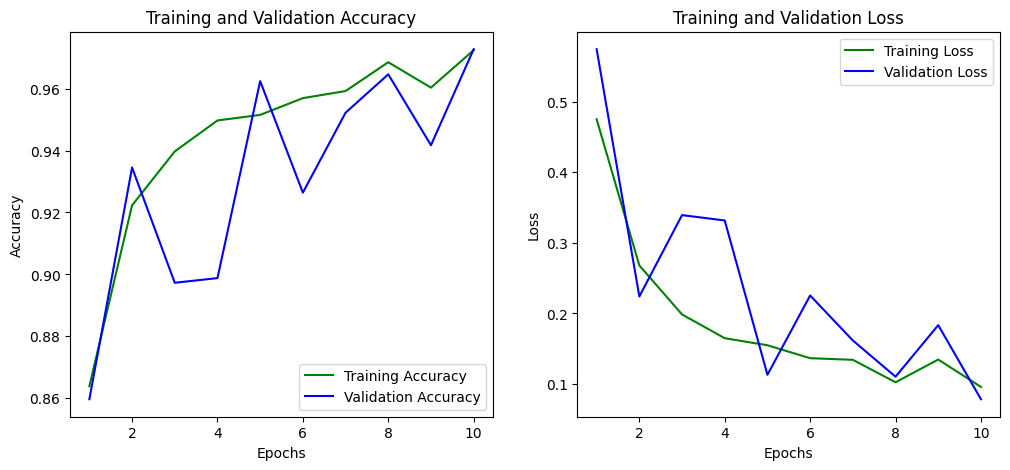

In [ ]:
acc_train = xception.history['accuracy']
acc_val = xception.history['val_accuracy']
loss_train = xception.history['loss']
loss_val = xception.history['val_loss']
epochs = range(1,11)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
results_df_2 = pd.DataFrame(data=[["Xception", (accuracy_xception*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,93.577415
1,VGG16,88.116664
2,VGG19,80.825317
3,DenseNet121,94.663358
4,DenseNet201,95.811355
5,InceptionV3,93.205088
6,Xception,97.549629


#### Using Custom CNN Model

In [ ]:
model=Sequential()

#convolution layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(66,66,3)))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(32,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#global average pooling
model.add(GlobalAveragePooling2D())
#fully connected layer
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(BatchNormalization())

#output layer
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                        

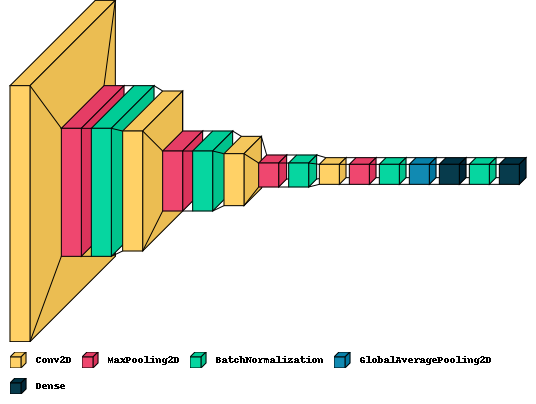

In [ ]:
#To display the CNN model architecture
visualkeras.layered_view(model, legend=True)

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_custom_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
custom = model.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
806/806 [==============================] - 68s 79ms/step - loss: 0.2108 - accuracy: 0.9312 - precision: 0.9373 - recall: 0.9270 - val_loss: 0.2226 - val_accuracy: 0.9271 - val_precision: 0.9327 - val_recall: 0.9212
Epoch 2/20
806/806 [==============================] - 60s 74ms/step - loss: 0.2051 - accuracy: 0.9323 - precision: 0.9378 - recall: 0.9273 - val_loss: 0.1859 - val_accuracy: 0.9392 - val_precision: 0.9433 - val_recall: 0.9351
Epoch 3/20
806/806 [==============================] - 60s 74ms/step - loss: 0.1972 - accuracy: 0.9366 - precision: 0.9411 - recall: 0.9319 - val_loss: 0.1625 - val_accuracy: 0.9488 - val_precision: 0.9525 - val_recall: 0.9466
Epoch 4/20
806/806 [==============================] - 60s 74ms/step - loss: 0.1961 - accuracy: 0.9349 - precision: 0.9399 - recall: 0.9304 - val_loss: 0.1988 - val_accuracy: 0.9342 - val_precision: 0.9386 - val_recall: 0.9299
Epoch 5/20
806/806 [==============================] - 60s 74ms/step - loss: 0.1923 - accuracy: 0

In [ ]:
#Loading the best fit model
custom_model = load_model("./oc_custom_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_custom = custom_model.evaluate_generator(generator= test_data)[1]
precision_custom = custom_model.evaluate_generator(generator= test_data)[2]
recall_custom = custom_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_custom*100} %")
print(f"Precision = {precision_custom*100} %")
print(f"Recall = {recall_custom*100} %")

<ipython-input-15-42bba74b5eb6>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_custom = custom_model.evaluate_generator(generator= test_data)[1]
<ipython-input-15-42bba74b5eb6>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_custom = custom_model.evaluate_generator(generator= test_data)[2]
<ipython-input-15-42bba74b5eb6>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_custom = custom_model.evaluate_generator(generator= test_data)[3]


Accuracy = 94.7874665260315 %
Precision = 95.04209756851196 %
Recall = 94.57027316093445 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["Custom", (accuracy_custom*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Testing Accuracy %
0,ResNet50,93.577415
1,VGG16,88.116664
2,VGG19,80.825317
3,DenseNet121,94.663358
4,DenseNet201,95.811355
5,InceptionV3,93.205088
6,Xception,97.549629
7,Custom,94.787467


In [ ]:
models_test_acc = [accuracy_resnet, accuracy_vgg, accuracy_vgg19, accuracy_densenet121, accuracy_densenet, accuracy_incep, accuracy_xception, accuracy_custom]
accuracy_scores = []
for model in models_test_acc:
    accuracy_scores.append(model)
print(accuracy_scores)

[0.9357741475105286, 0.8811666369438171, 0.8082531690597534, 0.9466335773468018, 0.9581135511398315, 0.932050883769989, 0.9754962921142578, 0.947874665260315]


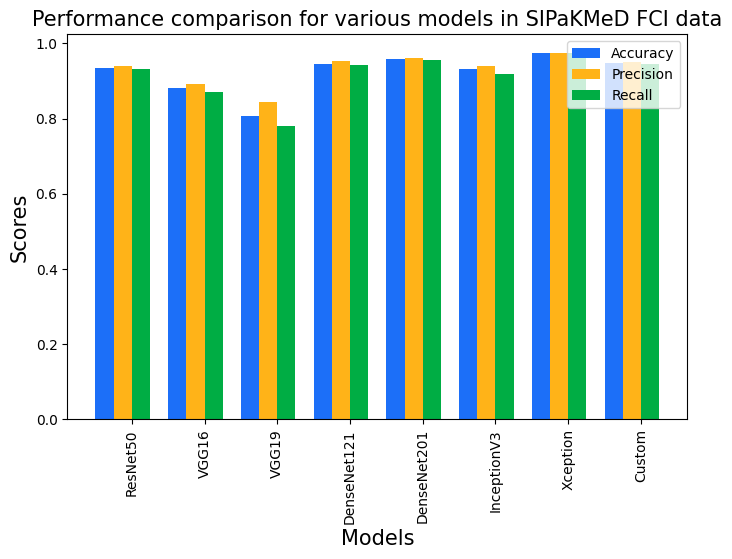

In [ ]:
ind = np.arange(8)
width = 0.25
fig, ax = plt.subplots(figsize=(8,5))

accu = [accuracy_resnet, accuracy_vgg, accuracy_vgg19, accuracy_densenet121, accuracy_densenet, accuracy_incep, accuracy_xception, accuracy_custom]
rects1 = ax.bar(ind, accu, width,color='#1c6ff8')
prec = [precision_resnet, precision_vgg, precision_vgg19, precision_densenet121, precision_densenet, precision_incep, precision_xception, precision_custom]
rects2 = ax.bar(ind+width, prec, width,color='#ffb318')
rec = [recall_resnet, recall_vgg, recall_vgg19, recall_densenet121, recall_densenet, recall_incep, recall_xception, recall_custom]
rects3 = ax.bar(ind + 2 * width, rec, width,color='#00ad44')

ax.set_xlabel('Models', fontsize=15)
ax.set_ylabel('Scores', fontsize=15)
ax.set_title('Performance comparison for various models in SIPaKMeD FCI data', fontsize=15)
ax.set_xticks(ind + 1.5*width)
ax.set_xticklabels(('ResNet50','VGG16','VGG19','DenseNet121','DenseNet201','InceptionV3','Xception','Custom'))
ax.legend((rects1[0], rects2[0], rects3[0]), ('Accuracy', 'Precision', 'Recall'))
plt.xticks(rotation=90)
plt.show()

Inference: It is clear from the barplot that Xception model shows the highest performance.